# Statistical Deviation Event Detector

For the eye activation detection task, there is a clear trend in the data - measuring the data with open eyes outputs a clearly different DC Voltage than measuring the data with eyes closed. This can be observed in the sample data below.

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch

## Experimenting with scale & deviation for Point Process Generation

In [3]:
#Digilent WaveForms Oscilloscope Acquisition
#Device Name: Discovery2
#Serial Number: SN:210321B5D9FA
#Date Time: 2025-02-13 12:33:16.223
#Sample rate: 136.533Hz
#Samples: 5800
#Trigger: Source: Channel 1 Type: Edge Condition: Rising Level: 0 V Hyst.: Auto HoldOff: 0 s
#Channel 1: Range: 200 mV/div Offset: -2 V Sample Mode: Average
#Channel 2: Range: 500 mV/div Offset: 0 V Sample Mode: Average
#Power Supplies: ON
#Positive Supply: ON
#Voltage: 5 V
#Negative Supply: ON
#Voltage: -5 V

## Statistical Deviation Event Detector Calculations

In [4]:
def apply_sded(x, eff_dc, alpha, delta):
    new_eff_dc = alpha * x + (1 - alpha) * eff_dc
    spike = 1 if np.abs(x - new_eff_dc) > delta else 0
    return new_eff_dc, spike

def apply_sded_full(x, alpha, delta):
    eff_dc = np.zeros_like(x)
    spike = np.zeros_like(x)
    for i in range(1, len(x)):
        eff_dc[i], spike[i] = apply_sded(x[i], eff_dc[i-1], alpha, delta)
    return eff_dc, spike

SDED Experiment

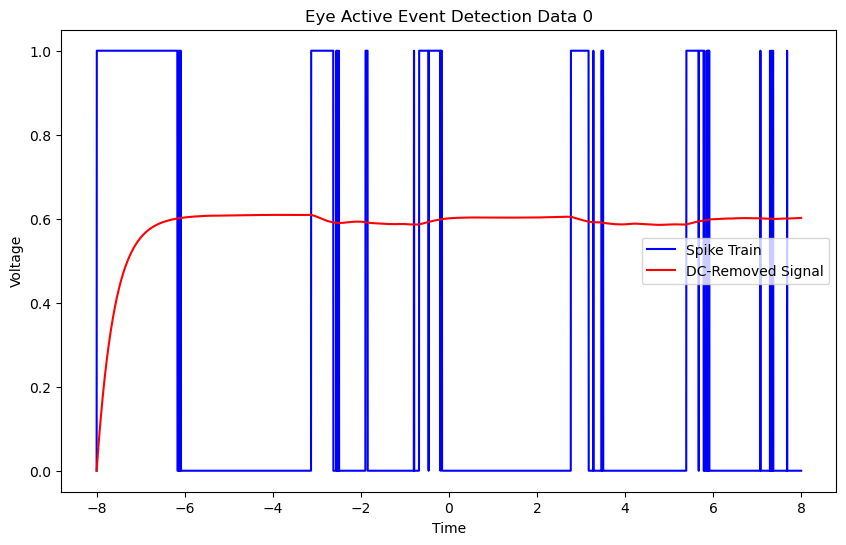

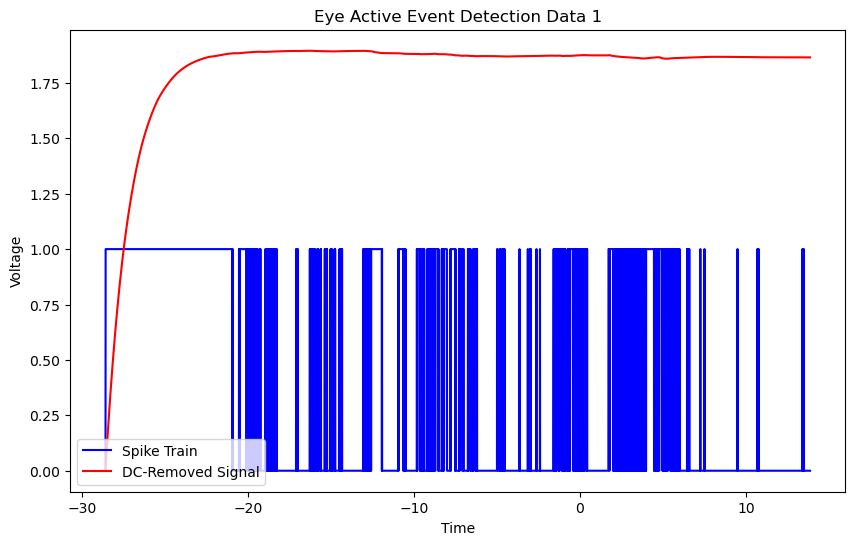

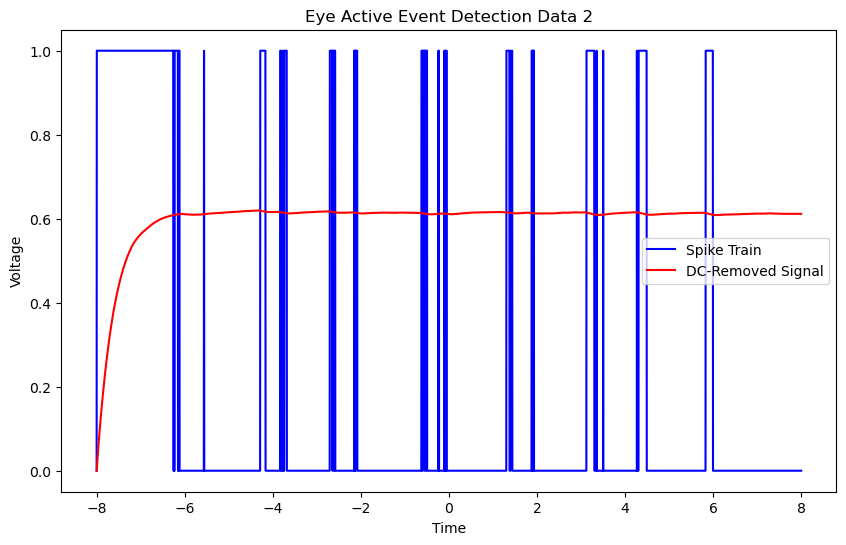

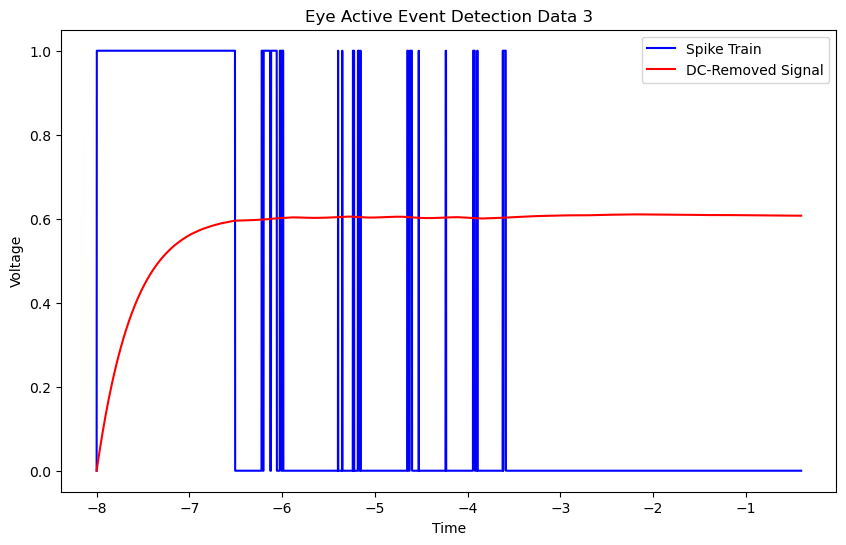

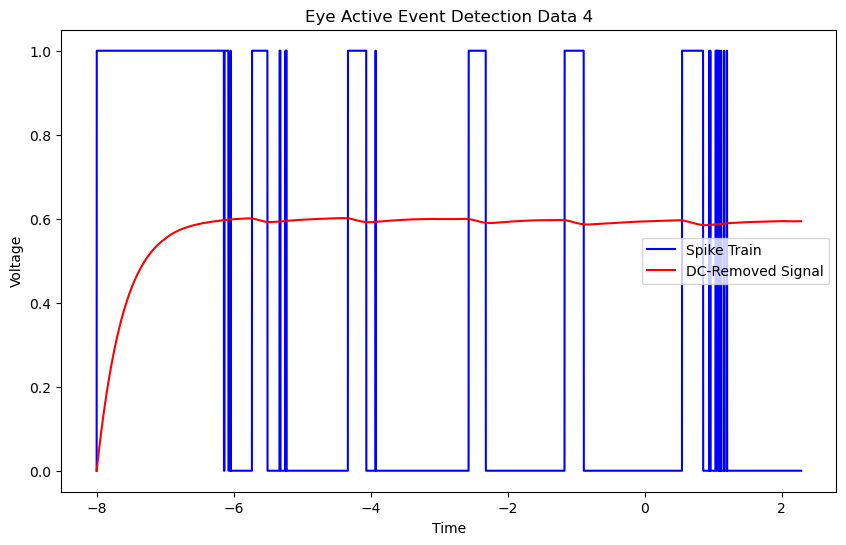

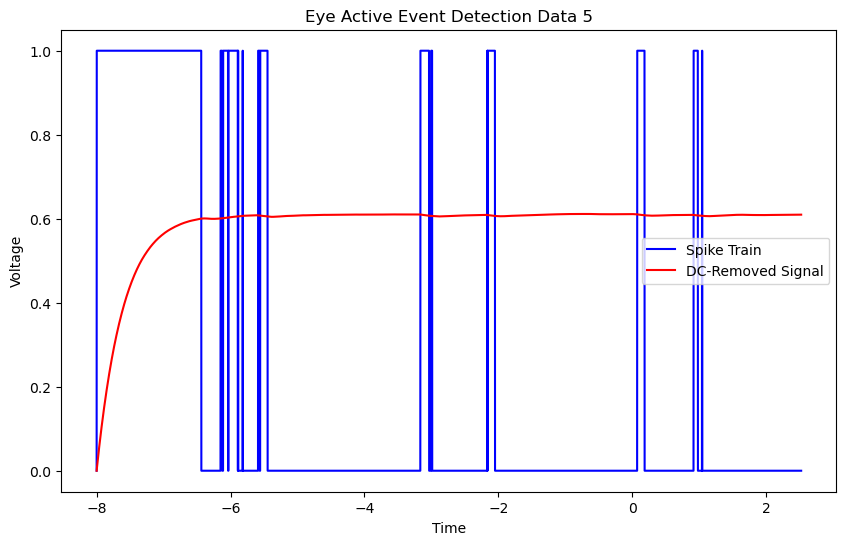

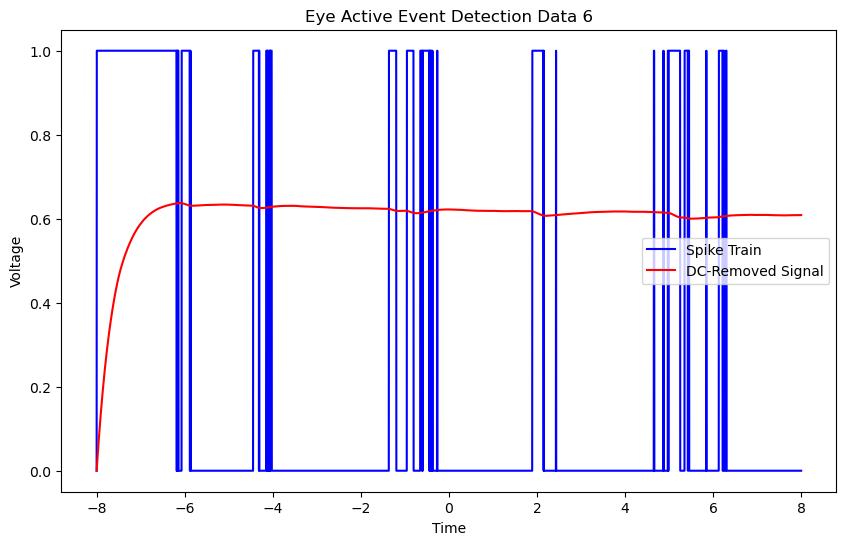

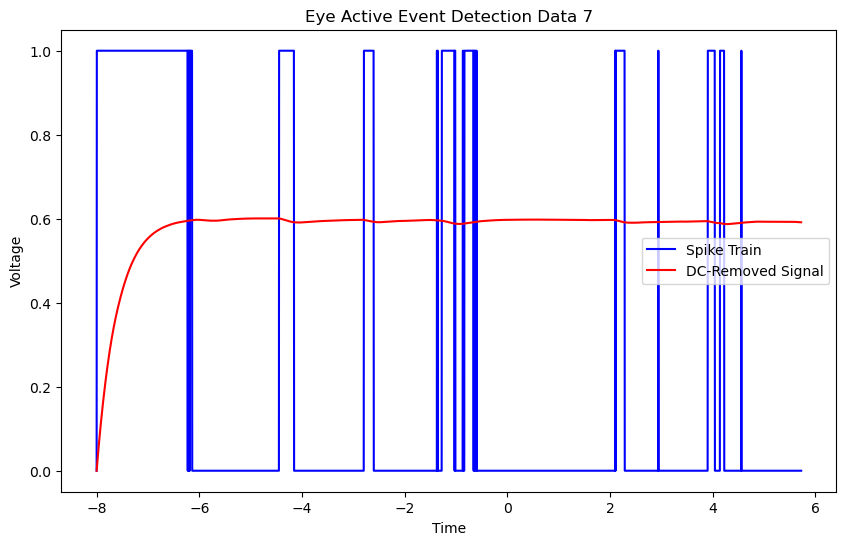

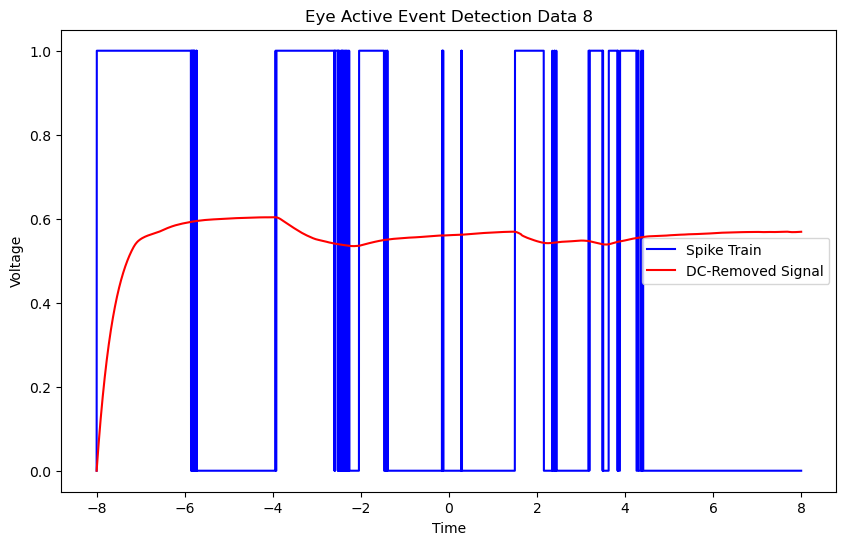

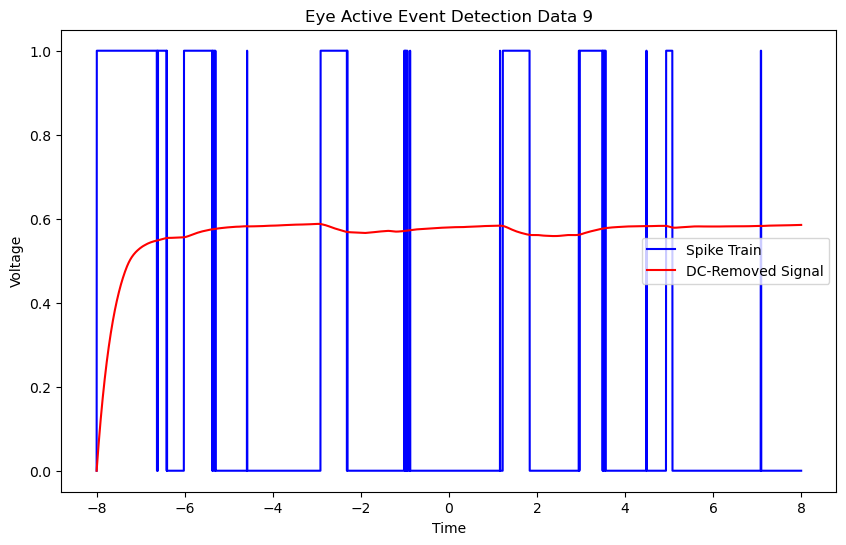

Average Standard Deviation: 0


In [7]:
M = 10
filter = - np.ones(M) / np.sqrt(M)
applied_filter = 0
scale = 1.2
deviation = 0.005477277382981891 # Empirically determined standard deviation threshold
threshold = scale*deviation # Empirically determined standard deviation threshold
alpha = 0.005

avg_std = 0

#for i in range(10):
for i in range(10):
    # Load the data
    data = pd.read_csv(f'eye_blinking{i}.csv', delimiter=',')
    # Drop Channel2
    data = data.drop(columns=['Channel2'])
    voltage = data['Channel1']
    time = data['Time']
    N = len(voltage)
    # Apply the filter
    dc_removed_voltage, spike_train = apply_sded_full(voltage, alpha, threshold)

    # Plot the event detection
    plt.figure(figsize=(10, 6))
    plt.plot(time, spike_train, 'b', label='Spike Train')
    plt.plot(time, dc_removed_voltage, 'r', label='DC-Removed Signal')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title(f'Eye Active Event Detection Data {i}')
    plt.show()

print(f'Average Standard Deviation: {avg_std}')

